In [186]:
#library wjaib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
#support library
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sktime.forecasting.naive import NaiveForecaster
warnings.filterwarnings('ignore')
#testting performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

DAPATKAN DATA YANG DIBUTUHKAN

In [187]:
df_holiday = pd.read_csv('data/holidays_events.csv')
df_stores = pd.read_csv('data/stores.csv')
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')
df_oil = pd.read_csv('data/oil.csv')

MUAT SEMUA VARIABLE PREDIKSI PADA DATA TEST

In [188]:


df_test['date'] = pd.to_datetime(df_test['date'])

city_holidays = df_holiday.locale_name.unique()
city_stores = df_stores.city.unique()
not_in_city = [x for x in city_holidays if x not in city_stores]
# df_test['city'] = [df_stores[df_stores['store_nbr'] == x ]['city'].values[0] for x in df_test['store_nbr'] ]
df_test['city'] = pd.merge(df_test, df_stores[['store_nbr', 'city']], on='store_nbr')['city']#menambahkan kota

#add holiday
for type_holiday in df_holiday.type.unique():
    in_holiday = df_holiday[df_holiday['type'] == type_holiday]['date']
    df_test[type_holiday] = df_test['date'].isin(in_holiday).astype(int)
#kelompokkan family product dan store number
df_test['family'] = "S" + df_test['store_nbr'].astype(str) + "_" + df_test['family'].astype(str)
df_test.drop(['id'], axis=1, inplace=True)
df_test.set_index('date', inplace=True)
#detect  new year
df_test['new_year'] = df_test.index.dayofyear == 1

df_test

,store_nbr,family,onpromotion,city,Holiday,Transfer,Additional,Bridge,Work Day,Event,new_year
date,,,,,,,,,,,
2017-08-16,1,S1_AUTOMOTIVE,0,Quito,0,0,0,0,0,0,False
2017-08-16,1,S1_BABY CARE,0,Quito,0,0,0,0,0,0,False
2017-08-16,1,S1_BEAUTY,2,Quito,0,0,0,0,0,0,False
2017-08-16,1,S1_BEVERAGES,20,Quito,0,0,0,0,0,0,False
2017-08-16,1,S1_BOOKS,0,Quito,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,9,S9_POULTRY,1,Quito,0,0,0,0,0,0,False
2017-08-31,9,S9_PREPARED FOODS,0,Quito,0,0,0,0,0,0,False
2017-08-31,9,S9_PRODUCE,1,Quito,0,0,0,0,0,0,False


MUAT SEMUA VARIABLE PADA DATA TRAIN

In [189]:
df_train['date'] = pd.to_datetime(df_train['date'])#rubah format date
df_train['city'] = pd.merge(df_train, df_stores[['store_nbr', 'city']], on='store_nbr')['city']#menambahkan kota

#kelompokkan family product dan store number
df_train['family'] = "S" + df_train['store_nbr'].astype(str) + "_" + df_train['family'].astype(str)
df_train.drop(['id'], axis=1, inplace=True)

df_train.set_index('date', inplace=True)
#detect new year



df_train

,store_nbr,family,sales,onpromotion,city
date,,,,,
2013-01-01,1,S1_AUTOMOTIVE,0.000,0,Quito
2013-01-01,1,S1_BABY CARE,0.000,0,Quito
2013-01-01,1,S1_BEAUTY,0.000,0,Quito
2013-01-01,1,S1_BEVERAGES,0.000,0,Quito
2013-01-01,1,S1_BOOKS,0.000,0,Quito
...,...,...,...,...,...
2017-08-15,9,S9_POULTRY,438.133,0,Quito
2017-08-15,9,S9_PREPARED FOODS,154.553,1,Quito
2017-08-15,9,S9_PRODUCE,2419.729,148,Quito


BUILD MODEL

In [190]:
######## prepare data TRAIN ########

#prepare data train
def build_data(d, order=13, order_dp=1):
    y = d.pivot(columns='family', values='sales')
    #get missing
    def g_m_d(data):
        # get_missing_date = df_train[['sales']]
        get_missing_date = data.resample("D").sum()
        get_missing_date = get_missing_date[get_missing_date['sales'] == 0].drop(columns='sales')
        return get_missing_date
    get_missing_date = g_m_d(df_train[['sales']])
    #add missing date to data
    y = pd.concat([y, get_missing_date], axis=0)
    y.sort_index(inplace=True)
    y.fillna(0, inplace=True)
    # y = y.loc['2017']
    #add holiday
    y.rename_axis("item", axis="columns", inplace=True)
    y.index = y.index.astype('period[D]')

    fourier = CalendarFourier(freq="M", order=order)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=order_dp,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    X = dp.in_sample()
    for type_holiday in df_holiday.type.unique():
        in_holiday = df_holiday[df_holiday['type'] == type_holiday]['date']
        X[type_holiday] = X.index.isin(in_holiday).astype(bool)
    X['new_year'] = X.index.dayofyear == 1#add new year
    ## add harga oil
    #### prepare data oil
    def oil():
        df_oil.index = df_oil['date']
        df_oil.index = df_oil.index.astype('datetime64[ns]')
        df_oil_ = df_oil.resample("D").sum()

        # missing value
        nan_to_0 = df_oil_['dcoilwtico'].replace(np.nan, 0)
        nan_to_0 = np.array(nan_to_0).reshape(-1, 8)
        mean_val = [np.mean(x[~(x==0.0)]) for x in nan_to_0] #dapatkan nilai mean
        result_array = [[round(mean_val[i], 2) if val == 0.0 else val for val in row] for i, row in enumerate(nan_to_0)] #replace nilai 0.0 dengan mean
        df_oil_['harga'] = np.array(result_array).reshape(-1,1) #reshape array untuk dijadikan kolom
        # df = df.to_frame()
        df_new_oil = df_oil_['harga']
        oil = df_new_oil.to_frame()
        return oil[:len(y)]
    oil_price = oil()
    X['oil_price'] = np.array(oil_price['harga'])

    return X,y
X, y = build_data(df_train)

X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"sin(13,freq=M)","cos(13,freq=M)",Holiday,Transfer,Additional,Bridge,Work Day,Event,new_year,oil_price
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,False,False,False,False,False,False,True,93.13
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.485302,-0.874347,False,False,False,False,False,False,False,93.14
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,-0.848644,0.528964,False,False,False,False,False,False,False,92.97
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.998717,-0.050649,False,False,False,False,False,False,False,93.12
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,-0.897805,-0.440394,False,False,False,False,False,False,False,93.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1684.0,0.0,0.0,1.0,0.0,0.0,0.0,0.897805,-0.440394,...,0.937752,0.347305,False,False,False,False,False,False,False,48.81
2017-08-12,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,0.790776,-0.612106,...,-0.651372,-0.758758,False,False,False,False,False,False,False,48.53
2017-08-13,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,0.651372,-0.758758,...,0.201299,0.979530,False,False,False,False,False,False,False,48.53


In [191]:
df_oil[:len(y)]

,date,dcoilwtico
date,,
2013-01-01,2013-01-01,NaN
2013-01-02,2013-01-02,93.14
2013-01-03,2013-01-03,92.97
2013-01-04,2013-01-04,93.12
2013-01-07,2013-01-07,93.20
...,...,...
2017-08-25,2017-08-25,47.65
2017-08-28,2017-08-28,46.40
2017-08-29,2017-08-29,46.46


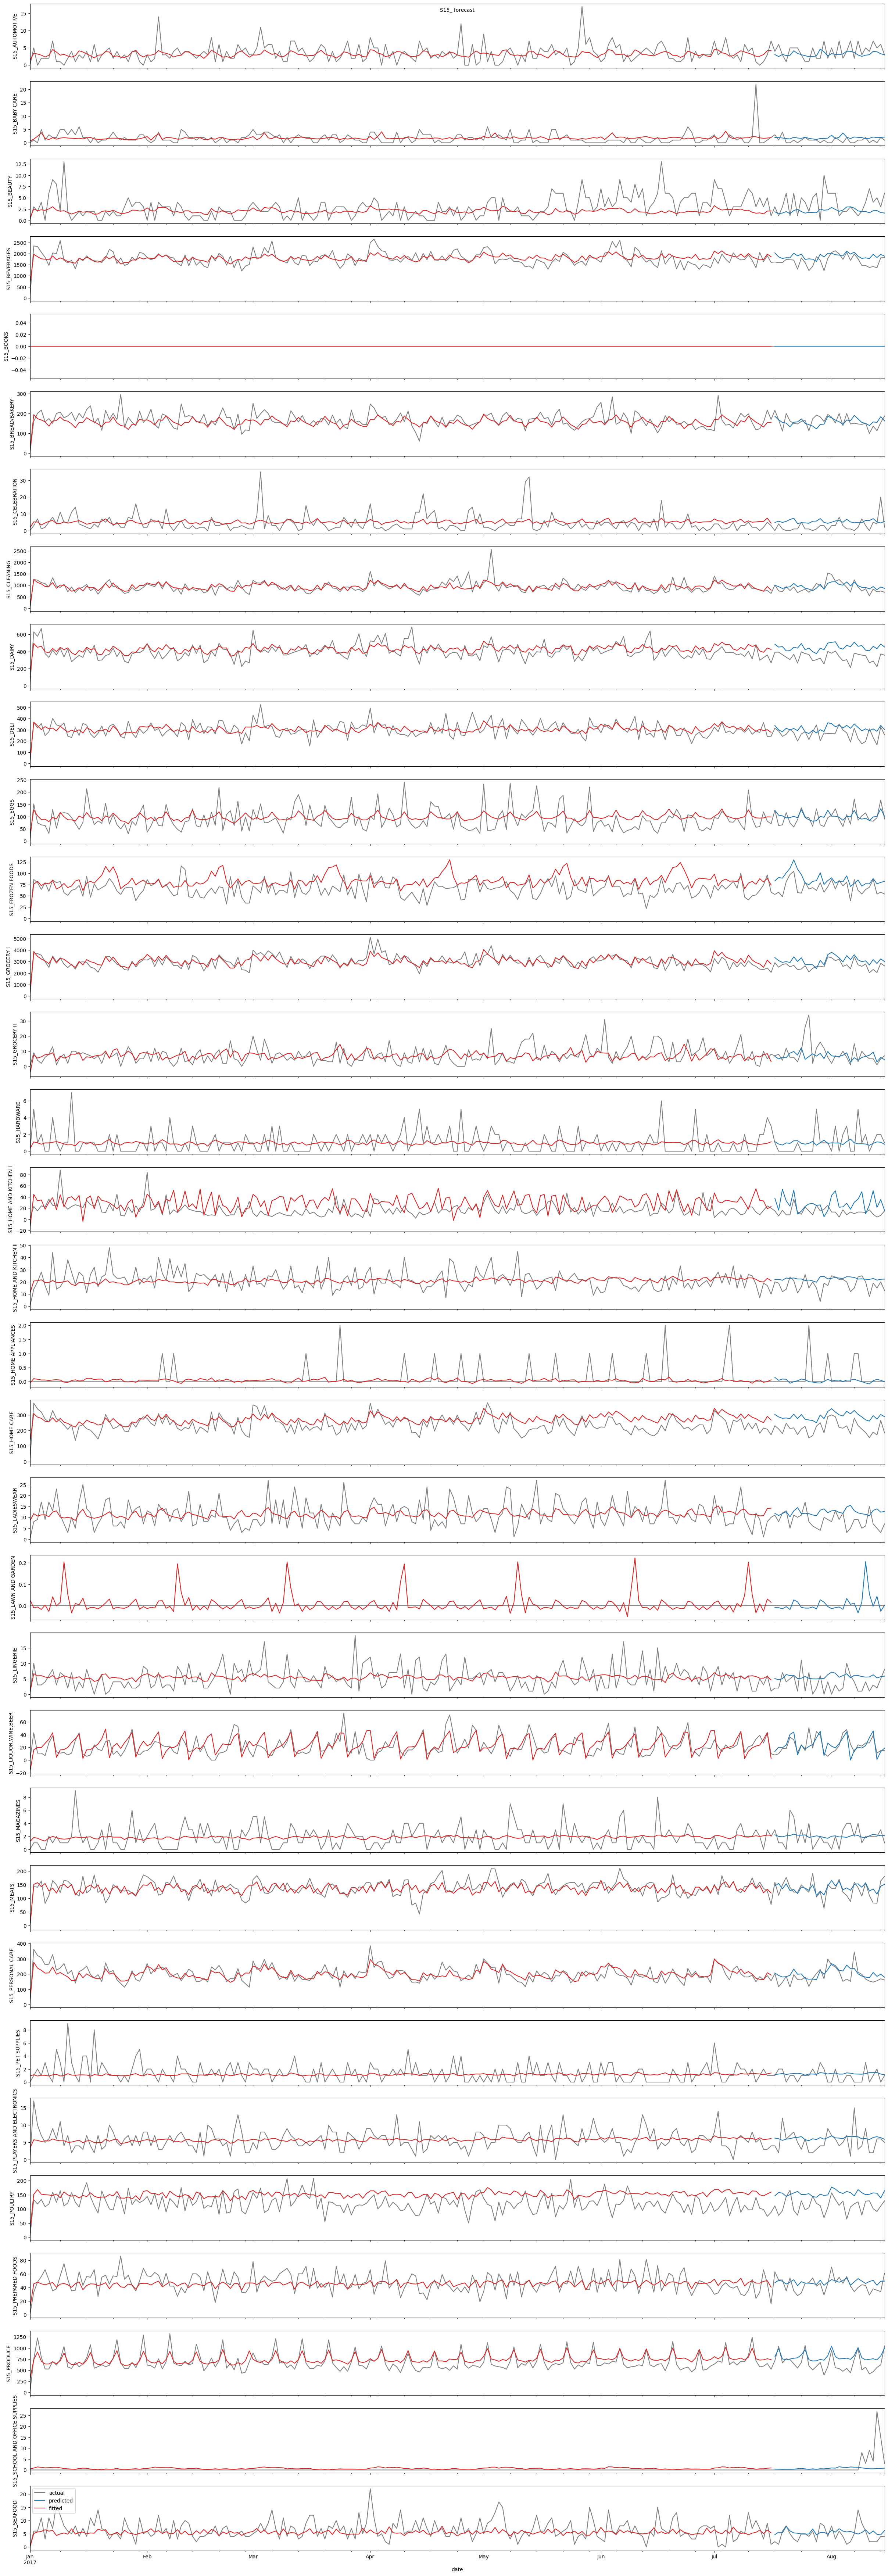

In [192]:
#split data train and test
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

model = LinearRegression()#create model
model.fit(X_train, y_train)#fitting model
pred = model.predict(X_test)#predict
pred_ = pd.DataFrame(pred, index=y_test.index, columns=y_test.columns)#dataframe predict
# display(pred)
# display(y_test)

### coba buat plotting prediksi
st = "S15_"
col = y_test.columns[y_test.columns.str.contains(st)]#dapatkan kolom
pred = pred_[col]#dapatkan prediksi
y_test = y_test[col]#data actual
y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)#fitted
y_fit = y_fit[col]#fitted

def plot():
    y_ = y.loc['2017'][col]
    # y_test = y_test.loc['2017']
    pred_ = pred.loc['2017']
    y_fit_ = y_fit.loc['2017']

    axs = y_.loc(axis=1)[col].plot(subplots=True, sharex=True, color='black',figsize=(30, 90), alpha=0.5, legend=False) #actual 
    # _ = y_test.plot(subplots=True, sharex=True, color='black', ax=axs, alpha=0.2,legend=False)#valid data test
    _ = pred_.plot(subplots=True, sharex=True, color='tab:blue', label='predicted', ax=axs, legend=False)#prediksi
    _ = y_fit_.plot(subplots=True, sharex=True, color='tab:red', label='fitted', ax=axs, legend=False)#fitted prediksi
    plt.text(0.5, 0.9, f'{st} forecast', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
    # plt.ylabel(np.char.replace(col.to_list(), 'S10_', ''), size=8)
    # plt.subplots().set_ylabel(np.char.replace(col.to_list(), 'S10_', ''), size=8)
    for i, ax in enumerate(axs):
        ax.set_ylabel(y_.columns[i])
    plt.legend(['actual', 'predicted', 'fitted'], loc='upper left')
    plt.show()
plot()


In [193]:
############# test performa model ############
df_predict = pd.concat([y_fit, pred], axis=0).sort_index()
df_valid = y[col]


df_mean_mape = pd.DataFrame([mean_absolute_percentage_error(df_predict[x], df_valid[x]) for x in col], index=col, columns=["MAPE"])

df_mean_mape_good_performance = df_mean_mape[df_mean_mape['MAPE'] <= 1]
df_mean_mape_bad_performance = df_mean_mape[df_mean_mape['MAPE'] > 1]

display(df_mean_mape_good_performance) #df_mean_mape_bad_performance
display(df_mean_mape_bad_performance)

,MAPE
item,
S15_AUTOMOTIVE,0.614079
S15_BEAUTY,0.720185
S15_BEVERAGES,0.217735
S15_BOOKS,0.000000
S15_BREAD/BAKERY,0.182627
S15_CLEANING,0.147757
S15_DAIRY,0.204416
S15_DELI,0.172953
S15_EGGS,0.340666


,MAPE
item,
S15_BABY CARE,1.090893
S15_CELEBRATION,1.105588
S15_HOME AND KITCHEN I,3.715888
S15_HOME APPLIANCES,3.016589
S15_LAWN AND GARDEN,1.040946
"S15_LIQUOR,WINE,BEER",1.476180
S15_PET SUPPLIES,1.287695
S15_SCHOOL AND OFFICE SUPPLIES,2.258040


In [194]:
######## mencari nilai mape semua toko ########
### dibagi setitap family product ####

mape_all_store = pd.DataFrame()#hasil mape

for stores in df_stores['store_nbr']:
    s = f"S{stores}_"#buat kode toko sekaligus menjadi kolumn
    columns_ = np.array(y.columns[y.columns.str.contains(s)]).astype(str)#dapatkan kolom untuk toko semua family product
    name_index = np.char.replace(columns_, s, '')#hapus karakter S*_ untuk dijadikan index


    predicted = pd.concat( [pred_[columns_], pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns) ] ).sort_index()[columns_]#dapatkan prediksi 
    actual = y[columns_]#data actual
    mape_ = pd.DataFrame([mean_absolute_percentage_error(predicted[x], actual[x]) for x in columns_], index=name_index, columns=[s])#hitung mape
    
    mape_all_store[s] = mape_[s]#tambahkan data ke mape_all_store
    mape_all_store.set_index(mape_.index, inplace=True)#set index ke mape_all_store


####### mencari rata-rata mape setiap toko ########
mean_setiap_toko = pd.DataFrame([mape_all_store[x].mean().round(9) for x in mape_all_store.columns], index=mape_all_store.columns, columns=["MAPE"])

mean_setiap_toko.sort_values(by=['MAPE'], ascending=True)

# mean_setiap_toko['MAPE'].mean()

,MAPE
S3_,0.510353
S49_,0.530059
S7_,0.544852
S44_,0.553181
S51_,0.556962
S47_,0.560423
S8_,0.564995
S45_,0.580365
S27_,0.595867
S11_,0.610832


RMSLE pereforma

In [195]:
def rmsle(y_true, y_pred):
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    suqre_diff = (log_pred - log_true) ** 2
    mean_squared_diff = np.mean(suqre_diff)

    rmsle_score = np.sqrt(mean_squared_diff)
    return rmsle_score
    # return np.sqrt(mean_squared_error(y_true, y_pred))


In [196]:

def create_df_performa(model_ukur=mean_absolute_percentage_error, model=model):
    perform = pd.DataFrame()#hasil mape

    for stores in df_stores['store_nbr']:
        s = f"S{stores}_"#buat kode toko sekaligus menjadi kolumn
        columns_ = np.array(y.columns[y.columns.str.contains(s)]).astype(str)#dapatkan kolom untuk toko semua family product
        name_index = np.char.replace(columns_, s, '')#hapus karakter S*_ untuk dijadikan index


        predicted = pd.concat( [pred_[columns_], pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns) ] ).sort_index()[columns_]#dapatkan prediksi 
        actual = y[columns_]#data actual
        performa = pd.DataFrame([model_ukur(np.array(predicted[x]), np.array(actual[x])) for x in columns_], index=name_index, columns=[s])#hitung mape
# 
        perform[s] = performa[s]#tambahkan data ke mape_all_store
        perform.set_index(mape_.index, inplace=True)#set index ke mape_all_store
    return perform
mape__ = create_df_performa(model_ukur=mean_absolute_percentage_error)
rmsle__ = create_df_performa(model_ukur=rmsle)

########## mencari rata-rata rmsle setiap toko ########
rmsle_semua_toko = pd.DataFrame([rmsle__[x].mean().round(9) for x in rmsle__.columns], index=rmsle__.columns, columns=["RMSLE"])
print("RMSLE: ",rmsle_semua_toko['RMSLE'].mean())

mape_semua_toko = pd.DataFrame([mape__[x].mean().round(9) for x in mape__.columns], index=mape__.columns, columns=["MAPE"])
print("MAPE: ",mape_semua_toko['MAPE'].mean())

# r2_semua_toko = pd.DataFrame([r2__[x].mean().round(9) for x in r2__.columns], index=r2__.columns, columns=["R2"])
# print("r2 : ",r2_semua_toko['R2'].mean())

RMSLE:  0.3668403417037037
MAPE:  0.7297674426851851


ORDERS 

========= orders 24 =========

MAPE : 0.7528862540925924

RMSLE : 0.3736316256481482

========= orders 31 ========

MAPE : 0.7463447827777777

RMSLE : 0.35866894422222223

========== orders 13 ============

MAPE : 0.7323883022592594

RMSLE : 0.3753365455

In [197]:
### bad performa
import re

bad_performance = mean_setiap_toko[mean_setiap_toko['MAPE'] > 1]#mencari toko yang bad performa diatas 1
store_bad_performa = np.array(bad_performance.index)

store = [int(re.search(r'S(\d+)', txt).group(1)) for txt in store_bad_performa]#dapatakan toko sesuai store_bad_performa

df_train_bad = df_train[df_train['store_nbr'].isin(store)]

# df_train_bad
bad_performance


,MAPE
S36_,1.014997
S52_,1.059880
